# LOEWE Campaign Analysis

This notebook presents the data preprocessing, sentiment analysis, and exploratory
analysis of Instagram comments related to the LOEWE campaign.

The same analytical pipeline is applied across all brand campaigns in this study.

In [1]:
# Import Libraries

import pandas as pd
import numpy as np
import re
import string
import regex
import matplotlib.pyplot as plt
import contractions
import emoji
import seaborn as sns
import os
from collections import Counter
from translate import Translator
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from langdetect import detect
from textblob import TextBlob
from sklearn.metrics import confusion_matrix

# NLTK downloads
nltk.download('vader_lexicon')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Pilar\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pilar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Data Loading

This section loads the dataset containing Instagram comments for the campaign.


In [2]:
# Load Data
file_path = "../data/Loewe-Ig-comments-translated.xlsx"
df = pd.read_excel(file_path)

print("DataFrame shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head(10)

DataFrame shape: (2119, 4)
Columns: ['Nº', 'Date', 'Comment', 'Translated_Comment']


,Nº,Date,Comment,Translated_Comment
0,1,2023-01-19 17:10:08,I am screaming out of my tight twat!,I am screaming out of my tight twat!
1,2,2023-01-19 17:13:01,I’m so jealous. 😢,I’m so jealous. 😢
2,3,2023-01-19 17:13:20,😍,😍
3,4,2023-01-19 17:16:44,Aaaaa ah!!!🖤,Aaaaaah!!!🖤
4,5,2023-01-19 22:55:57,Final??? NOOOO 😭😭😭,Final??? NOOOO 😭😭😭
5,6,2023-01-19 23:00:41,😍,😍
6,7,2023-01-19 23:02:31,😍,😍
7,8,2023-01-19 23:11:47,@amy_mymouse 🙈,@amy_mymouse 🙈
8,9,2023-01-19 23:16:12,insane,insane
9,10,2023-01-19 23:39:43,Can.not.wait!!!,Can.not.wait!!!


## Data Cleaning

Basic preprocessing steps are applied to clean and standardize the text data,
including the removal of noise and formatting issues.


In [3]:
# Copy original dataframe
df_loewe = df.copy()

# Clean function 
def clean_comment(text):
    """
    Remove mentions, links, punctuation, extra spaces, invisible/control characters,
    variation selectors (U+FE0F), and convert to lowercase.
    """
    if pd.isna(text):
        return ""
    
    text = str(text)
    text = re.sub(r'@\w+', '', text)                  # remove mentions
    text = re.sub(r'http\S+|www.\S+', '', text)      # remove links
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)  # remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()         # remove extra spaces

    # Remove invisible/control Unicode characters
    # Includes zero-width spaces, non-breaking spaces, BOM, etc.
    text = re.sub(r'[\u200B-\u200D\uFEFF]', '', text)  # zero-width chars + BOM + variation selector
    text = re.sub(r'[\x00-\x1F\x7F]', '', text)       # ASCII control chars

    # Remove additional variation selectors that might appear en emojis (U+FE0F)
    text = re.sub(r'\uFE0F', '', text)

    return text.lower()

# Apply cleaning 
df_loewe["Clean_Comment"] = df_loewe["Translated_Comment"].apply(clean_comment)

# Remove comments that are empty after cleaning 
df_loewe = df_loewe[df_loewe["Clean_Comment"].str.strip() != ""]

# Reset index 
df_loewe.reset_index(drop=True, inplace=True)

# Display first 10 rows 
df_loewe.head(10)

,Nº,Date,Comment,Translated_Comment,Clean_Comment
0,1,2023-01-19 17:10:08,I am screaming out of my tight twat!,I am screaming out of my tight twat!,i am screaming out of my tight twat
1,2,2023-01-19 17:13:01,I’m so jealous. 😢,I’m so jealous. 😢,i’m so jealous 😢
2,3,2023-01-19 17:13:20,😍,😍,😍
3,4,2023-01-19 17:16:44,Aaaaa ah!!!🖤,Aaaaaah!!!🖤,aaaaaah🖤
4,5,2023-01-19 22:55:57,Final??? NOOOO 😭😭😭,Final??? NOOOO 😭😭😭,final noooo 😭😭😭
5,6,2023-01-19 23:00:41,😍,😍,😍
6,7,2023-01-19 23:02:31,😍,😍,😍
7,8,2023-01-19 23:11:47,@amy_mymouse 🙈,@amy_mymouse 🙈,🙈
8,9,2023-01-19 23:16:12,insane,insane,insane
9,10,2023-01-19 23:39:43,Can.not.wait!!!,Can.not.wait!!!,cannotwait


In [4]:
def remove_stopwords_keep_emojis(text):
    """
    Expand English contractions, remove stopwords according to detected language,
    and keep emojis intact.
    """
    if not isinstance(text, str) or text.strip() == "":
        return ""
    
    # Expand contractions
    text = contractions.fix(text)
    
    # Detect language
    try:
        lang = detect(text)
    except:
        lang = 'en'
    
    # Load stopwords, fallback to English
    if lang in stopwords.fileids():
        sw = set(stopwords.words(lang))
    else:
        sw = set(stopwords.words('english'))
    
    # Split words, remove stopwords, keep everything else including emojis
    words = text.split()
    filtered = [w for w in words if w.lower() not in sw]  # lowercase comparison
    
    return " ".join(filtered).strip()

# Apply to dataframe
df_loewe["Processed_Comment"] = df_loewe["Clean_Comment"].apply(remove_stopwords_keep_emojis)

# Display first 10 rows to verify
df_loewe.head(10)


,Nº,Date,Comment,Translated_Comment,Clean_Comment,Processed_Comment
0,1,2023-01-19 17:10:08,I am screaming out of my tight twat!,I am screaming out of my tight twat!,i am screaming out of my tight twat,screaming tight twat
1,2,2023-01-19 17:13:01,I’m so jealous. 😢,I’m so jealous. 😢,i’m so jealous 😢,jealous 😢
2,3,2023-01-19 17:13:20,😍,😍,😍,😍
3,4,2023-01-19 17:16:44,Aaaaa ah!!!🖤,Aaaaaah!!!🖤,aaaaaah🖤,aaaaaah🖤
4,5,2023-01-19 22:55:57,Final??? NOOOO 😭😭😭,Final??? NOOOO 😭😭😭,final noooo 😭😭😭,final noooo 😭😭😭
5,6,2023-01-19 23:00:41,😍,😍,😍,😍
6,7,2023-01-19 23:02:31,😍,😍,😍,😍
7,8,2023-01-19 23:11:47,@amy_mymouse 🙈,@amy_mymouse 🙈,🙈,🙈
8,9,2023-01-19 23:16:12,insane,insane,insane,insane
9,10,2023-01-19 23:39:43,Can.not.wait!!!,Can.not.wait!!!,cannotwait,cannotwait


In [5]:
# Normalize Date Column

df_loewe["Date"] = pd.to_datetime(df_loewe["Date"], errors="coerce").dt.normalize()

df_loewe.head(10)

,Nº,Date,Comment,Translated_Comment,Clean_Comment,Processed_Comment
0,1,2023-01-19,I am screaming out of my tight twat!,I am screaming out of my tight twat!,i am screaming out of my tight twat,screaming tight twat
1,2,2023-01-19,I’m so jealous. 😢,I’m so jealous. 😢,i’m so jealous 😢,jealous 😢
2,3,2023-01-19,😍,😍,😍,😍
3,4,2023-01-19,Aaaaa ah!!!🖤,Aaaaaah!!!🖤,aaaaaah🖤,aaaaaah🖤
4,5,2023-01-19,Final??? NOOOO 😭😭😭,Final??? NOOOO 😭😭😭,final noooo 😭😭😭,final noooo 😭😭😭
5,6,2023-01-19,😍,😍,😍,😍
6,7,2023-01-19,😍,😍,😍,😍
7,8,2023-01-19,@amy_mymouse 🙈,@amy_mymouse 🙈,🙈,🙈
8,9,2023-01-19,insane,insane,insane,insane
9,10,2023-01-19,Can.not.wait!!!,Can.not.wait!!!,cannotwait,cannotwait


In [6]:
# Function to extract emojis from a text
def extract_emojis(text):
    return [char for char in text if emoji.is_emoji(char)]

# Extract all emojis from the "Processed_Comment" column
all_emojis = []
for comment in df_loewe["Processed_Comment"].dropna():
    all_emojis.extend(extract_emojis(comment))

# Count the frequency of each emoji
emoji_counts = Counter(all_emojis)

# Display the results
for e, count in emoji_counts.most_common():
    print(f"{e}: {count}")

# List of unique emojis
unique_emojis = list(emoji_counts.keys())
print("All emojis:", unique_emojis)

😍: 997
❤: 696
🔥: 391
😭: 134
👏: 92
🥹: 75
😢: 69
🙌: 67
💔: 40
⭐: 38
😂: 36
🥺: 34
♥: 30
😮: 30
🤍: 27
💙: 25
🖤: 20
🏻: 20
🥲: 20
🥰: 18
🫶: 18
✨: 17
💖: 17
💗: 16
🤩: 13
😩: 13
🏼: 13
😱: 11
💜: 9
🐑: 9
🤎: 8
🤣: 8
💟: 7
🙏: 7
💛: 7
💣: 7
👌: 6
🏽: 6
🍀: 6
🥶: 6
💘: 6
🤮: 6
🖌: 6
🫠: 5
💪: 5
😳: 5
💕: 4
🌀: 4
💸: 4
🤤: 4
👁: 4
🐶: 4
⚡: 4
🧡: 4
😻: 4
😅: 4
💚: 4
🤧: 4
‼: 3
🧐: 3
🫢: 3
🧎: 3
♀: 3
😊: 3
☁: 3
💫: 3
💞: 3
🦋: 3
🙈: 2
💨: 2
💌: 2
💅: 2
🌸: 2
💥: 2
👍: 2
👀: 2
🍌: 2
🍋: 2
🥑: 2
🍐: 2
🍏: 2
🥝: 2
🍈: 2
🥥: 2
🍑: 2
🍎: 2
🍇: 2
🍓: 2
🍊: 2
😔: 2
🏰: 2
😘: 2
😃: 2
👄: 2
🤌: 2
🤔: 2
😒: 2
🎸: 2
🎼: 2
♂: 2
🤯: 2
🚪: 2
🏾: 2
💐: 2
🤭: 2
🩵: 2
🫰: 1
🤗: 1
🪞: 1
🤽: 1
👩: 1
🚀: 1
🌦: 1
🌎: 1
🪐: 1
✅: 1
😯: 1
☺: 1
🫵: 1
🛸: 1
🥵: 1
😓: 1
🐉: 1
🔮: 1
⏰: 1
🛐: 1
❣: 1
☠: 1
😿: 1
😀: 1
🧣: 1
🙂: 1
🐏: 1
🎨: 1
😗: 1
👋: 1
🎇: 1
🦄: 1
🌪: 1
🤦: 1
🌟: 1
📈: 1
📉: 1
🔻: 1
🎀: 1
🎆: 1
🌼: 1
👈: 1
👇: 1
👉: 1
👆: 1
😌: 1
🤷: 1
🧑: 1
🍳: 1
😈: 1
🥸: 1
👿: 1
😞: 1
💓: 1
👃: 1
🫂: 1
🫦: 1
🙁: 1
🌞: 1
😇: 1
🍒: 1
😋: 1
🩹: 1
🙆: 1
💎: 1
😬: 1
💝: 1
😣: 1
🤒: 1
🫴: 1
🫀: 1
😫: 1
💀: 1
🌚: 1
All emojis: ['😢', '😍', '🖤', '😭', '🙈', '🔥', '🥰', '🥹', '🫶', '🤩', '💟', 

In [7]:
# Create a dictionary with generic emoji meanings
emoji_dict = {}
for e in unique_emojis:
    if e in ['😍', '❤', '💕', '🖤', '💗', '💟', '💖', '💝', '💛', '💙', '💚', '🤎', '🤍', '🥰']:
        emoji_dict[e] = "love"
    elif e in ['😭', '😢', '😩', '😿', '😫', '😔', '🙁', '😣']:
        emoji_dict[e] = "sadness"
    elif e in ['😂', '🤣']:
        emoji_dict[e] = "fun"
    elif e in ['🔥', '💥', '⚡', '💣']:
        emoji_dict[e] = "excitement"
    elif e in ['🙌', '👏', '👍', '✅']:
        emoji_dict[e] = "approval"
    else:
        emoji_dict[e] = "other"  # Default category for uncategorized emojis

# Apply the dictionary to the Processed_Comment column
def replace_emojis(text, emoji_dict):
    if not isinstance(text, str):
        return ""
    for e, meaning in emoji_dict.items():
        text = text.replace(e, f" {meaning} ")
    return text

df_loewe['Processed_Comment'] = df_loewe['Processed_Comment'].apply(lambda x: replace_emojis(x, emoji_dict))

df_loewe.head(10)

,Nº,Date,Comment,Translated_Comment,Clean_Comment,Processed_Comment
0,1,2023-01-19,I am screaming out of my tight twat!,I am screaming out of my tight twat!,i am screaming out of my tight twat,screaming tight twat
1,2,2023-01-19,I’m so jealous. 😢,I’m so jealous. 😢,i’m so jealous 😢,jealous sadness
2,3,2023-01-19,😍,😍,😍,love
3,4,2023-01-19,Aaaaa ah!!!🖤,Aaaaaah!!!🖤,aaaaaah🖤,aaaaaah love
4,5,2023-01-19,Final??? NOOOO 😭😭😭,Final??? NOOOO 😭😭😭,final noooo 😭😭😭,final noooo sadness sadness sadness
5,6,2023-01-19,😍,😍,😍,love
6,7,2023-01-19,😍,😍,😍,love
7,8,2023-01-19,@amy_mymouse 🙈,@amy_mymouse 🙈,🙈,other
8,9,2023-01-19,insane,insane,insane,insane
9,10,2023-01-19,Can.not.wait!!!,Can.not.wait!!!,cannotwait,cannotwait


### Temporal Activity Analysis

This section examines the temporal distribution of user engagement across the
campaign period, focusing on daily activity patterns.


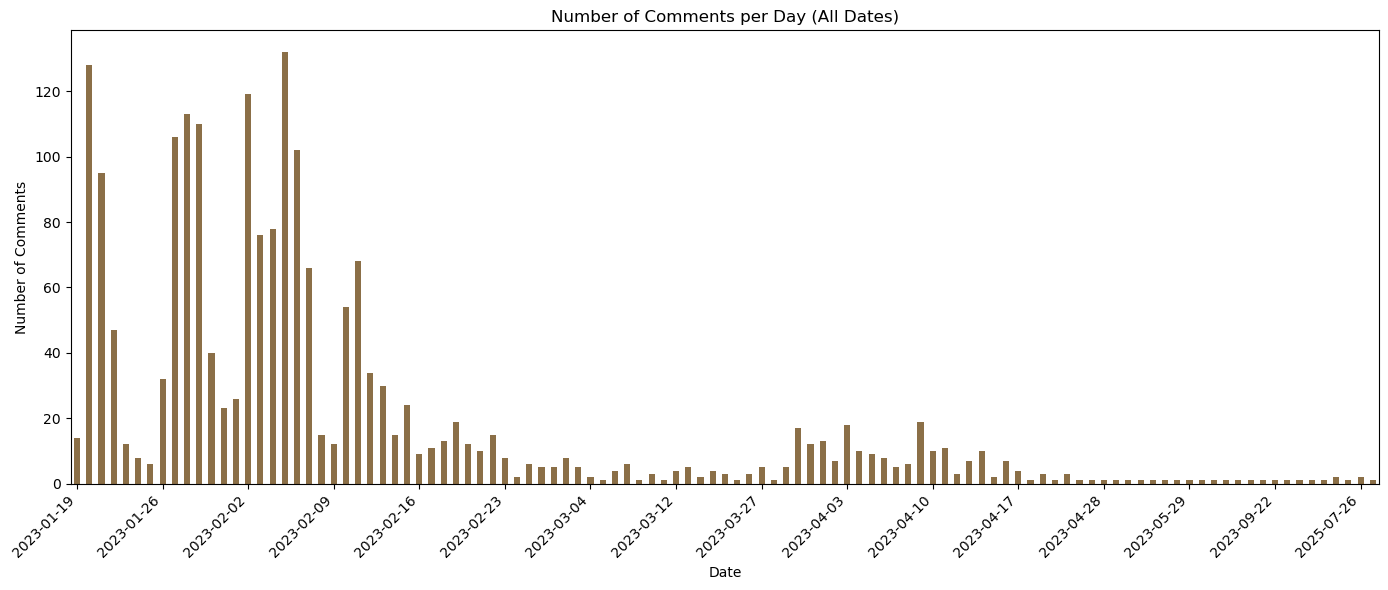

In [8]:
# Count comments per day (entire dataset)

comments_per_day = df_loewe.groupby("Date").size()

plt.figure(figsize=(14,6))
comments_per_day.plot(kind="bar", color="#8B6F47")
plt.title("Number of Comments per Day (All Dates)")
plt.xlabel("Date")
plt.ylabel("Number of Comments")

# Show only 1 out of every 7 dates to avoid clutter
skip_total = 7
plt.xticks(
    range(0, len(comments_per_day), skip_total),
    [d.strftime('%Y-%m-%d') for d in comments_per_day.index[::skip_total]],
    rotation=45,
    ha='right'
)
plt.tight_layout()

# SAVE FIGURE (important: before plt.show())
plt.savefig(
    r"C:\Users\Pilar\OneDrive - ISEG\Escritorio\TFM\graphs and figures\loewe_comments_per_day.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white"
)

plt.show()

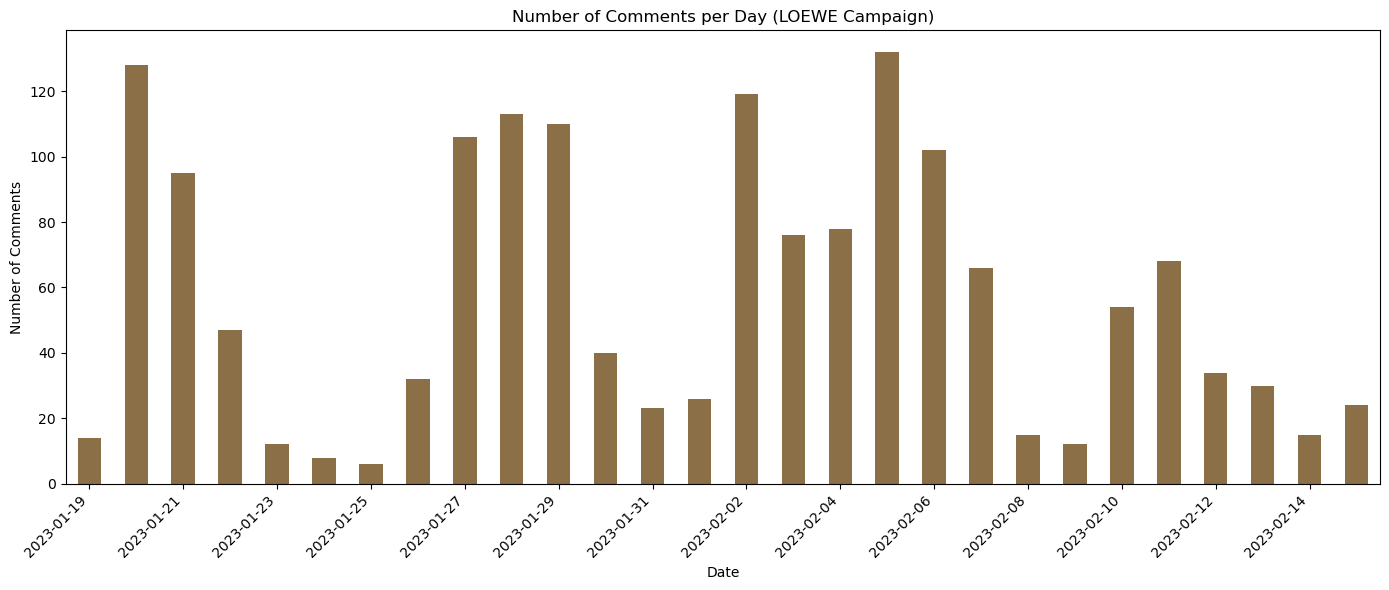

In [9]:
# Count comments per day during campaign period

# Define campaign start and end dates
start_date = pd.to_datetime("2023-01-19")
end_date = pd.to_datetime("2023-02-15")

# Filter DataFrame for campaign period
df_campaign = df_loewe[(df_loewe["Date"] >= start_date) & (df_loewe["Date"] <= end_date)]

# Count comments per day for campaign
comments_per_day_campaign = df_campaign.groupby("Date").size()

plt.figure(figsize=(14,6))
comments_per_day_campaign.plot(kind="bar", color="#8B6F47")
plt.title("Number of Comments per Day (LOEWE Campaign)")
plt.xlabel("Date")
plt.ylabel("Number of Comments")

# Show only every 2 days to avoid clutter
skip_campaign = 2
plt.xticks(
    range(0, len(comments_per_day_campaign), skip_campaign),
    [d.strftime('%Y-%m-%d') for d in comments_per_day_campaign.index[::skip_campaign]],
    rotation=45,
    ha='right'
)
plt.tight_layout()

# SAVE FIGURE (important: before plt.show())
plt.savefig(
    r"C:\Users\Pilar\OneDrive - ISEG\Escritorio\TFM\graphs and figures\loewe_comments_per_day_campaign_duration.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white"
)

plt.show()

## Sentiment Analysis

Sentiment analysis is performed using lexicon-based approaches to classify
user comments according to their polarity.


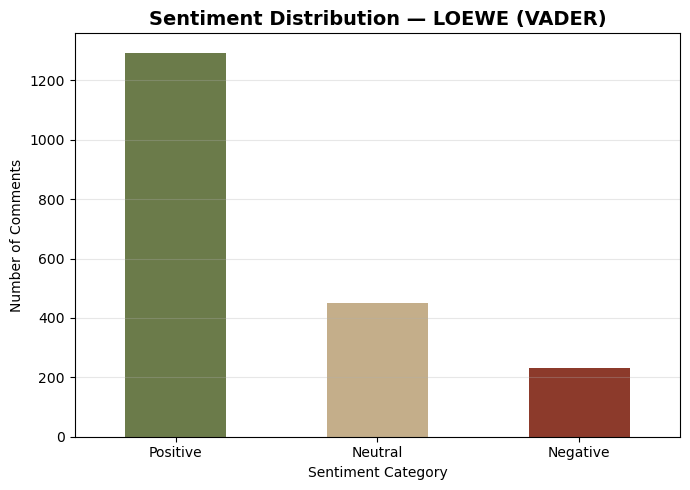

In [10]:
# Sentiment Analysis - VADER
sia = SentimentIntensityAnalyzer()

def classify_sentiment(comment):
    """
    Classifies the sentiment of a given comment using VADER's compound score.
    """
    if not isinstance(comment, str) or comment.strip() == "":
        return "Neutral"

    score = sia.polarity_scores(comment)["compound"]
    if score > 0.05:
        return "Positive"
    elif score < -0.05:
        return "Negative"
    else:
        return "Neutral"

# Apply sentiment classification
df_loewe["Sentiment"] = df_loewe["Processed_Comment"].apply(classify_sentiment)

# Ensure consistent order
order = ["Positive", "Neutral", "Negative"]
sentiment_counts = df_loewe["Sentiment"].value_counts().reindex(order, fill_value=0)

# LOEWE palette
loewe_colors = {
    "Positive": "#6B7B4A",  # green-brown
    "Neutral":  "#C4AE8A",  # light brown
    "Negative": "#8C3A2B"   # red-brown
}

plt.figure(figsize=(7,5))
sentiment_counts.plot(
    kind="bar",
    color=[loewe_colors[s] for s in sentiment_counts.index]
)

plt.title("Sentiment Distribution — LOEWE (VADER)", fontsize=14, weight="bold")
plt.xlabel("Sentiment Category")
plt.ylabel("Number of Comments")
plt.xticks(rotation=0)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()

# SAVE FIGURE (before show)
plt.savefig(
    r"C:\Users\Pilar\OneDrive - ISEG\Escritorio\TFM\graphs and figures\loewe_sentiment_distribution_vader.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white"
)

plt.show()

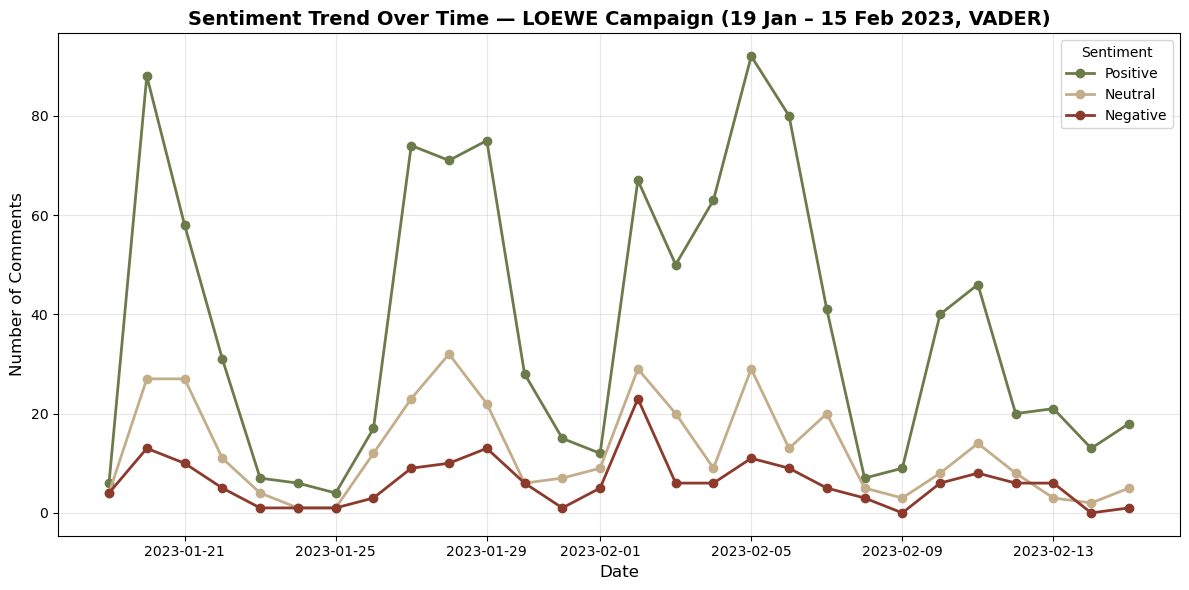

In [11]:
# Ensure 'Date' column is in datetime format and normalized
df_loewe["Date"] = pd.to_datetime(df_loewe["Date"], errors="coerce").dt.normalize()

# Define campaign period
start_date = pd.to_datetime("2023-01-19")
end_date = pd.to_datetime("2023-02-15")

# Filter dataset for campaign period
df_campaign = df_loewe[
    (df_loewe["Date"] >= start_date) & (df_loewe["Date"] <= end_date)
].copy()

# Group by date and sentiment category
sentiment_by_day = (
    df_campaign.groupby(["Date", "Sentiment"])
    .size()
    .unstack(fill_value=0)
)

# Ensure consistent sentiment order
sentiment_order = ["Positive", "Neutral", "Negative"]
sentiment_by_day = sentiment_by_day.reindex(columns=sentiment_order, fill_value=0)

# LOEWE sentiment color palette
loewe_sentiment_colors = {
    "Positive": "#6B7B4A",  # green-brown
    "Neutral":  "#C4AE8A",  # light brown
    "Negative": "#8C3A2B"   # red-brown
}

# Plot
plt.figure(figsize=(12, 6))

for sentiment in sentiment_order:
    plt.plot(
        sentiment_by_day.index,
        sentiment_by_day[sentiment],
        marker="o",
        linewidth=2,
        label=sentiment,
        color=loewe_sentiment_colors[sentiment]
    )

plt.title(
    "Sentiment Trend Over Time — LOEWE Campaign (19 Jan – 15 Feb 2023, VADER)",
    fontsize=14,
    weight="bold"
)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Comments", fontsize=12)
plt.legend(title="Sentiment", loc="upper right")
plt.grid(alpha=0.3)
plt.tight_layout()

# SAVE FIGURE
plt.savefig(
    r"C:\Users\Pilar\OneDrive - ISEG\Escritorio\TFM\graphs and figures\loewe_sentiment_trend_vader.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white"
)

plt.show()

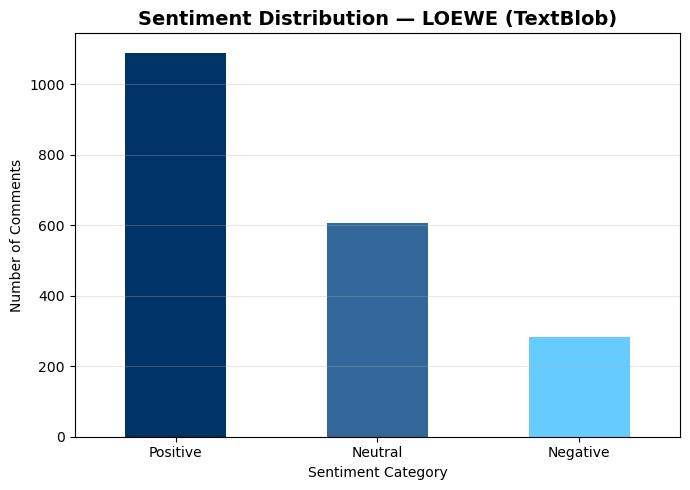

In [12]:
# Sentiment Analysis - TextBlob
def textblob_sentiment(comment):
    if not isinstance(comment, str) or comment.strip() == "":
        return "Neutral"
    
    polarity = TextBlob(comment).sentiment.polarity
    
    if polarity > 0.05:
        return "Positive"
    elif polarity < -0.05:
        return "Negative"
    else:
        return "Neutral"

df_loewe["Sentiment_TextBlob"] = df_loewe["Processed_Comment"].apply(textblob_sentiment)

# Contar comentarios por sentimiento
sentiment_counts_tb = df_loewe["Sentiment_TextBlob"].value_counts()

# Gráfico de barras con colores de identidad de marca
plt.figure(figsize=(7,5))
colors = ['#003366', '#336699', '#66ccff']  # tonos azules para LOEWE
sentiment_counts_tb.plot(kind="bar", color=colors)
plt.title("Sentiment Distribution — LOEWE (TextBlob)", fontsize=14, weight='bold')
plt.xlabel("Sentiment Category")
plt.ylabel("Number of Comments")
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

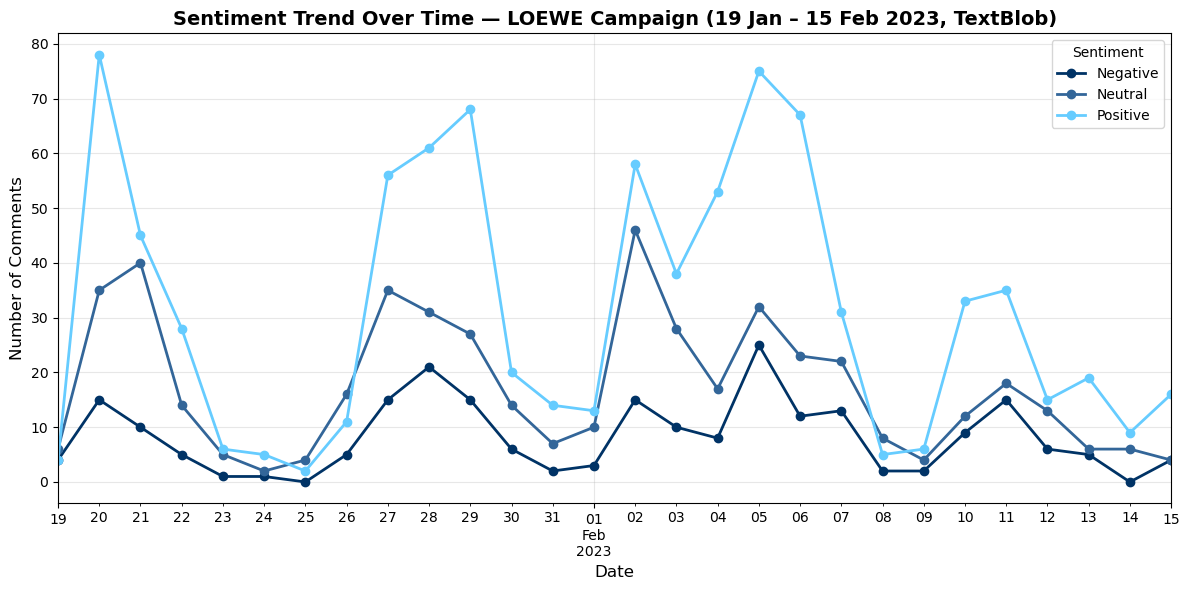

In [13]:
# Sentiment Trend Over Time — TextBlob

# Ensure 'Date' column is in datetime format and normalized (no time component)
df_loewe["Date"] = pd.to_datetime(df_loewe["Date"], errors="coerce").dt.normalize()

# Define campaign period
start_date = pd.to_datetime("2023-01-19")  # Cambia a las fechas reales de la campaña LOEWE
end_date = pd.to_datetime("2023-02-15")    # Cambia a las fechas reales de la campaña LOEWE

# Filter dataset for campaign period
df_campaign_tb = df_loewe[
    (df_loewe["Date"] >= start_date) & (df_loewe["Date"] <= end_date)
].copy()

# Group by date and sentiment category (TextBlob)
sentiment_tb_by_day = (
    df_campaign_tb.groupby(["Date", "Sentiment_TextBlob"])
    .size()
    .unstack(fill_value=0)
)

# Visualization: sentiment trend over time (TextBlob)
plt.figure(figsize=(12, 6))
sentiment_tb_by_day.plot(
    kind="line", 
    marker='o', 
    linewidth=2, 
    ax=plt.gca(), 
    color=['#003366', '#336699', '#66ccff']  # tonos azules para LOEWE
)

plt.title("Sentiment Trend Over Time — LOEWE Campaign (19 Jan – 15 Feb 2023, TextBlob)",
          fontsize=14, weight="bold")
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Comments", fontsize=12)
plt.legend(title="Sentiment", loc="upper right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

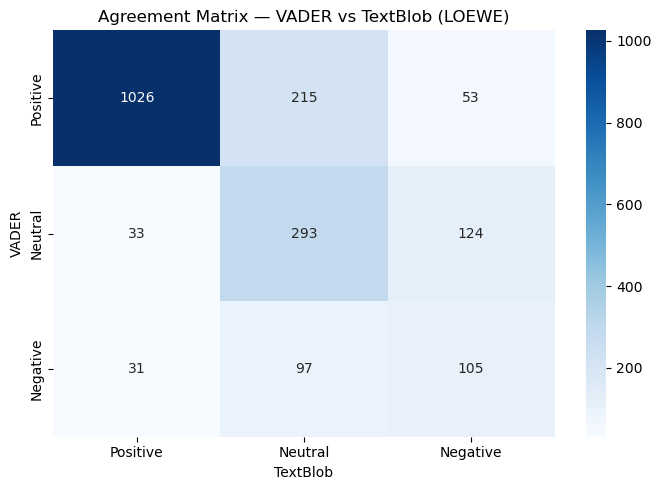

In [14]:
# Create matrix of vader vs textblob predictions
labels = ["Positive", "Neutral", "Negative"]

cm = confusion_matrix(
    df_loewe["Sentiment"],
    df_loewe["Sentiment_TextBlob"],
    labels=labels
)

plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels,
            yticklabels=labels)

plt.title("Agreement Matrix — VADER vs TextBlob (LOEWE)")
plt.xlabel("TextBlob")
plt.ylabel("VADER")
plt.tight_layout()
plt.show()

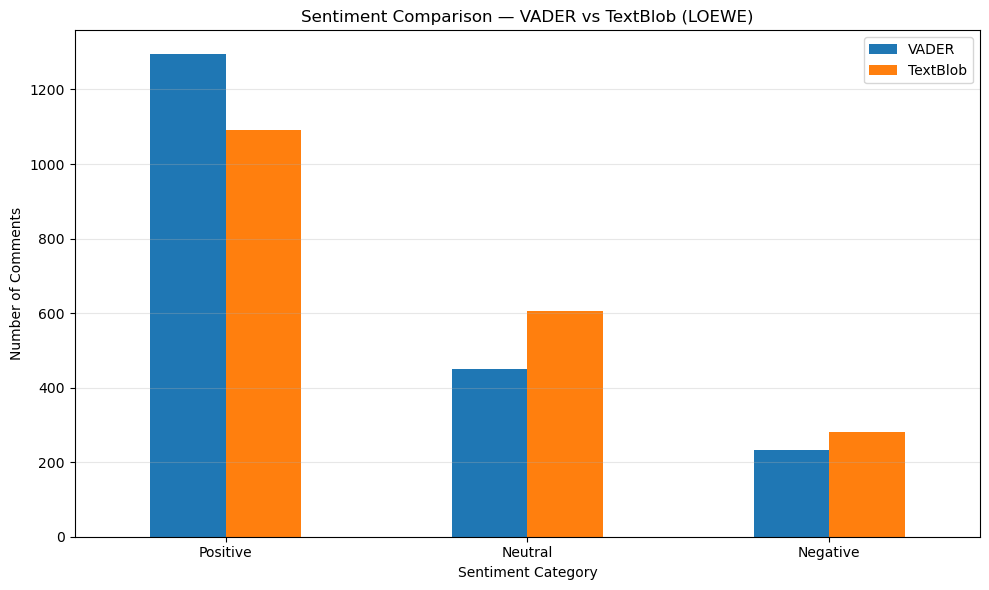

In [15]:
# Count sentiment categories for both methods
vader_counts = df_loewe["Sentiment"].value_counts().reindex(["Positive","Neutral","Negative"], fill_value=0)
textblob_counts = df_loewe["Sentiment_TextBlob"].value_counts().reindex(["Positive","Neutral","Negative"], fill_value=0)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    "VADER": vader_counts,
    "TextBlob": textblob_counts
})

# Plot
comparison_df.plot(kind="bar", figsize=(10,6))
plt.title("Sentiment Comparison — VADER vs TextBlob (LOEWE)")
plt.xlabel("Sentiment Category")
plt.ylabel("Number of Comments")
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

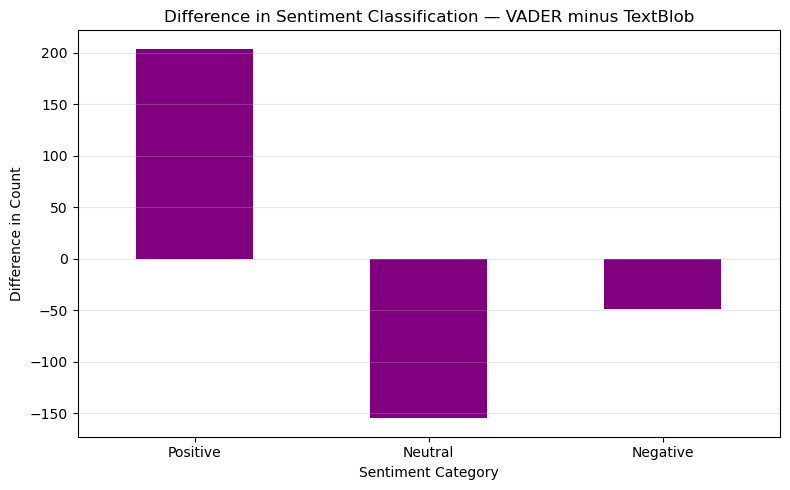

In [16]:
# Count sentiment categories for both methods
vader_counts = df_loewe["Sentiment"].value_counts().reindex(
    ["Positive", "Neutral", "Negative"], 
    fill_value=0
)

textblob_counts = df_loewe["Sentiment_TextBlob"].value_counts().reindex(
    ["Positive", "Neutral", "Negative"], 
    fill_value=0
)

difference = vader_counts - textblob_counts

plt.figure(figsize=(8,5))
difference.plot(kind="bar", color='purple')
plt.title("Difference in Sentiment Classification — VADER minus TextBlob")
plt.xlabel("Sentiment Category")
plt.ylabel("Difference in Count")
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Exploratory Analysis

This section explores frequent terms, emojis, and
other patterns in user engagement.

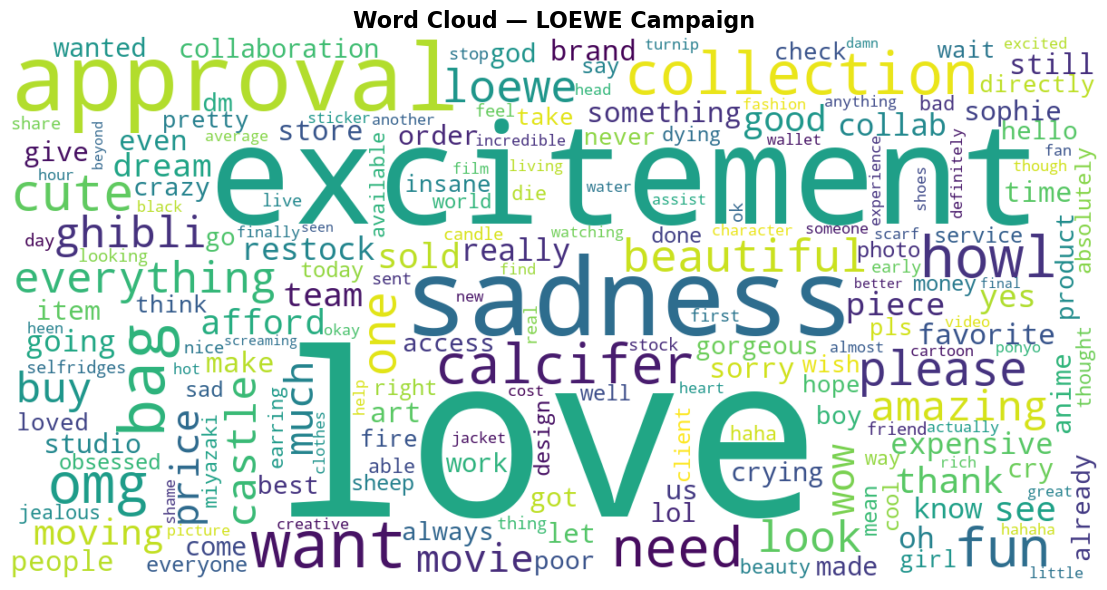

In [17]:
# Word Cloud Visualization 

# Combine all processed comments into a single string
all_text = " ".join(df_loewe["Processed_Comment"].dropna())

# Generate the Word Cloud
wordcloud = WordCloud(
    width=1200,
    height=600,
    background_color="white",
    colormap="viridis",        # Professional color palette
    max_words=200,             # Display up to 200 most frequent words
    contour_color="steelblue",
    contour_width=1,
    collocations=False,        # Avoids duplicate word pairs
    regexp=r'\S+'              # Keeps emojis and symbols as tokens
).generate(all_text)

# Display the Word Cloud-
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud — LOEWE Campaign", fontsize=16, weight="bold")
plt.tight_layout()
plt.show()

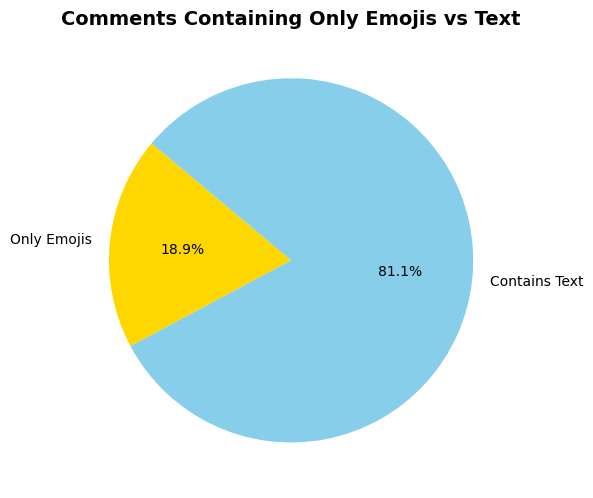

Comments containing only emojis: 374
Total comments analyzed: 1977
Percentage of emoji-only comments: 18.92%


In [18]:
# Emoji-Only Comments Analysis 

# Define pattern to detect emojis
emoji_pattern = re.compile(
    "[\U0001F600-\U0001F64F"  # Emoticons
    "\U0001F300-\U0001F5FF"   # Symbols & pictographs
    "\U0001F680-\U0001F6FF"   # Transport & map symbols
    "\U0001F1E0-\U0001F1FF"   # Flags
    "\U00002700-\U000027BF"   # Dingbats
    "\U0001F900-\U0001F9FF"   # Supplemental symbols and pictographs
    "\U00002600-\U000026FF"   # Misc symbols
    "]+", 
    flags=re.UNICODE
)

# Function: detect if a comment contains only emojis
def only_emojis(text):
    """
    Determines whether a comment is composed solely of emojis.

    Parameters
    ----------
    text : str
        Input text (comment).

    Returns
    -------
    bool
        True if the comment contains only emojis, False otherwise.
    """
    text = str(text).strip()
    if not text:
        return False
    # Remove spaces and test if only emojis remain
    no_spaces = re.sub(r"\s+", "", text)
    return bool(emoji_pattern.fullmatch(no_spaces))

# Apply detection to the translated comments (where emojis are preserved)
df_loewe["Only_Emojis"] = df_loewe["Translated_Comment"].apply(only_emojis)

# Count emoji-only vs text-containing comments
emoji_only_count = df_loewe["Only_Emojis"].sum()
text_count = len(df_loewe) - emoji_only_count

# Visualization: Emoji vs Text comments
plt.figure(figsize=(6, 6))
plt.pie(
    [emoji_only_count, text_count],
    labels=["Only Emojis", "Contains Text"],
    autopct="%1.1f%%",
    startangle=140,
    colors=["#FFD700", "#87CEEB"]
)
plt.title("Comments Containing Only Emojis vs Text", fontsize=14, weight="bold")
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Comments containing only emojis: {emoji_only_count}")
print(f"Total comments analyzed: {len(df_loewe)}")
print(f"Percentage of emoji-only comments: {emoji_only_count / len(df_loewe) * 100:.2f}%")

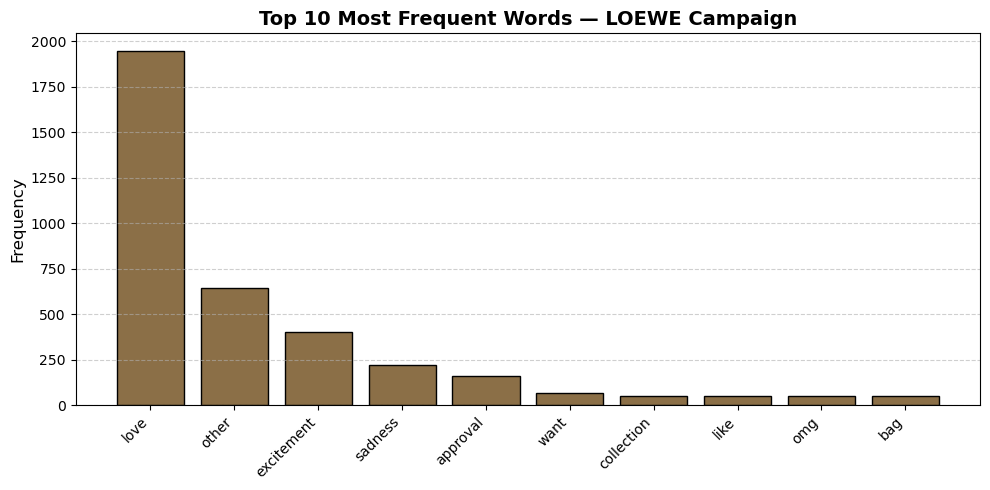

In [19]:
# Top 10 Most Frequent Words 

# Count word frequencies
all_text = " ".join(df_loewe["Processed_Comment"].dropna())
word_freq = Counter(all_text.split())

# Select top 10 most common words
top_10 = word_freq.most_common(10)
words, freqs = zip(*top_10)

# Visualization: Bar chart of most frequent words
plt.figure(figsize=(10, 5))
plt.bar(words, freqs, color="#8B6F47", edgecolor="black")

plt.title("Top 10 Most Frequent Words — LOEWE Campaign", fontsize=14, weight="bold")
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()

# SAVE FIGURE
plt.savefig(
    r"C:\Users\Pilar\OneDrive - ISEG\Escritorio\TFM\graphs and figures\loewe_top10_words.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white"
)

plt.show()

In [20]:
# Descriptive Summary

# Campaign parameters
start_date = pd.to_datetime("2023-01-19")
end_date = pd.to_datetime("2023-02-15")
campaign_duration = (end_date - start_date).days + 1

# Total number of comments
total_comments = len(df_loewe)

# Average number of elements (words/emojis) per comment
df_loewe["Element_Count"] = df_loewe["Processed_Comment"].apply(
    lambda x: len(str(x).split()) if pd.notnull(x) else 0
)
avg_elements = df_loewe["Element_Count"].mean()

# Day with the most comments
df_loewe["Date"] = pd.to_datetime(df_loewe["Date"], errors="coerce").dt.normalize()
comments_by_day = df_loewe.groupby("Date").size()

if not comments_by_day.empty:
    max_day = comments_by_day.idxmax().strftime("%Y-%m-%d")
    max_day_comments = int(comments_by_day.max())
    avg_comments_per_day = comments_by_day.mean()
else:
    max_day = "N/A"
    max_day_comments = 0
    avg_comments_per_day = 0

# Sentiment percentages
# Normalize sentiment labels to avoid case/spacing issues
sentiment_percentages = df_loewe["Sentiment"].str.strip().str.capitalize().value_counts(normalize=True) * 100

pos_pct = round(sentiment_percentages.get("Positive", 0), 1)
neg_pct = round(sentiment_percentages.get("Negative", 0), 1)
neu_pct = round(sentiment_percentages.get("Neutral", 0), 1)

# Most frequent elements (words)
all_words = " ".join(df_loewe["Processed_Comment"].dropna()).split()
top_3_words = [w for w, _ in Counter(all_words).most_common(3)]

# Build summary table
summary_data = {
    "Metric": [
        "Total Comments",
        "Average Elements per Comment",
        "Campaign Duration (days)",
        "Day with Most Comments",
        "Comments that Day",
        "Average Comments per Day",
        "Positive (%)",
        "Negative (%)",
        "Neutral (%)",
        "Top 3 Elements"
    ],
    "Value": [
        total_comments,
        round(avg_elements, 2),
        campaign_duration,
        max_day,
        max_day_comments,
        round(avg_comments_per_day, 2),
        pos_pct,
        neg_pct,
        neu_pct,
        ", ".join(top_3_words)
    ]
}

summary_table = pd.DataFrame(summary_data)

# Display summary table
display(summary_table)

,Metric,Value
0,Total Comments,1977
1,Average Elements per Comment,3.99
2,Campaign Duration (days),28
3,Day with Most Comments,2023-02-05
4,Comments that Day,132
5,Average Comments per Day,18.48
6,Positive (%),65.5
7,Negative (%),11.8
8,Neutral (%),22.8
9,Top 3 Elements,"love, other, excitement"


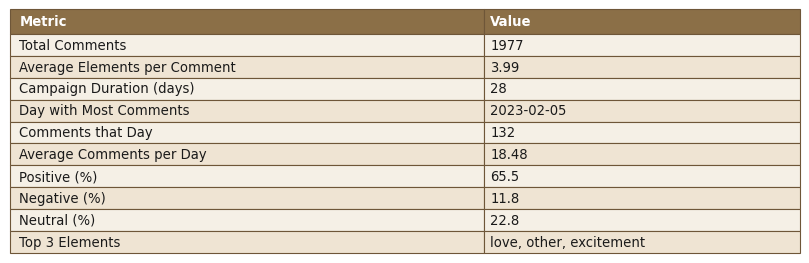

In [21]:
# RENDER COMPACT SUMMARY TABLE

HEADER_BG = "#8B6F47"   # LOEWE brown
ROW_BG_1  = "#F5F0E6"
ROW_BG_2  = "#EFE4D3"
EDGE_COL  = "#6E5638"
TEXT_COL  = "#1A1A1A"

# Smaller figure
n_rows = len(summary_table) + 1
fig_h = 0.38 * n_rows   # reduced height
fig, ax = plt.subplots(figsize=(8.2, fig_h))
ax.axis("off")

tbl = ax.table(
    cellText=summary_table.values,
    colLabels=summary_table.columns,
    cellLoc="left",
    colLoc="left",
    loc="center"
)

# Smaller font
tbl.auto_set_font_size(False)
tbl.set_fontsize(9.5)

for (row, col), cell in tbl.get_celld().items():
    cell.set_edgecolor(EDGE_COL)
    cell.set_linewidth(0.8)

    if row == 0:
        cell.set_facecolor(HEADER_BG)
        cell.get_text().set_color("white")
        cell.get_text().set_weight("bold")
        cell.set_height(0.18)
    else:
        cell.set_facecolor(ROW_BG_1 if row % 2 == 1 else ROW_BG_2)
        cell.get_text().set_color(TEXT_COL)
        cell.set_height(0.16)

    cell.PAD = 0.02  # less padding

# Column widths
for r in range(0, len(summary_table) + 1):
    tbl[(r, 0)].set_width(0.60)
    tbl[(r, 1)].set_width(0.40)

plt.tight_layout()

# SAVE
plt.savefig(
    r"C:\Users\Pilar\OneDrive - ISEG\Escritorio\TFM\graphs and figures\loewe_summary_table_compact.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white"
)

plt.show()


## Data Export

The processed dataset is exported to be used in the cross-brand comparative analysis.


In [22]:
df_loewe = df_loewe[["Nº", "Date", "Processed_Comment"]]
df_loewe["Brand"] = "Loewe"
df_loewe.head()

,Nº,Date,Processed_Comment,Brand
0,1,2023-01-19,screaming tight twat,Loewe
1,2,2023-01-19,jealous sadness,Loewe
2,3,2023-01-19,love,Loewe
3,4,2023-01-19,aaaaaah love,Loewe
4,5,2023-01-19,final noooo sadness sadness sadness,Loewe


In [23]:
# Create folder if it doesn't exist
os.makedirs("../data/processed", exist_ok=True)

# Save processed dataset for cross-brand analysis
output_path = "../data/processed/LOEWE-processed.xlsx"
df_loewe.to_excel(output_path, index=False)

print(f"Saved to: {output_path}")

Saved to: ../data/processed/LOEWE-processed.xlsx


## Summary

This notebook provides an overview of audience sentiment and engagement patterns
for the campaign, which will be compared across brands in the subsequent analysis.